#**Author: Piyush Sharma**

## **Machine Learning**

Implementation of NaiveBayes from scratch
testing the algorithm on famous & overused iris datset


# ---> Writing NaiveBayes from scratch.

1. Importing the libraries and reading the data.

In [1]:
#Importing the Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Read the dataset 
iris = pd.read_csv('https://raw.githubusercontent.com/Piyush9323/NaiveBayes_in_Python/main/iris.csv')
#iris.head()
iris.tail()


,Id,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica
149,150,5.9,3.0,5.1,1.8,Iris-virginica


2. Data Analysis

In [2]:
#iris.shape
#iris['Species'].value_counts()
#iris.columns
#iris.values
iris.info()
#iris.describe()
#iris.groupby('Species').size()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id           150 non-null    int64  
 1   SepalLength  150 non-null    float64
 2   SepalWidth   150 non-null    float64
 3   PetalLength  150 non-null    float64
 4   PetalWidth   150 non-null    float64
 5   Species      150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


3. Data visualization

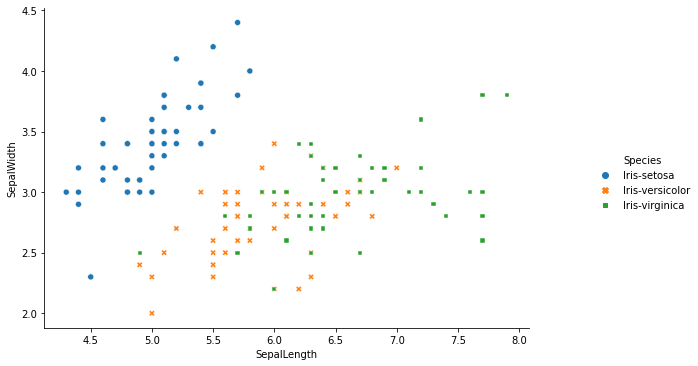

In [3]:
import seaborn as sns 
g=sns.relplot(x='SepalLength', y='SepalWidth', data=iris, hue = 'Species', style = 'Species')
g.fig.set_size_inches(10,5)
plt.show()

4. Preparing test and train data by spliting the iris datasets.

In [4]:
# This function splits the 150 data points into 120 train and 30 test datasets
def split_train_test(iris):
    # getting 80% data as training from each class
    train1 = iris.iloc[:50,:].sample(frac=0.8)
    train2 = iris.iloc[50:100].sample(frac=0.8)
    train3 = iris.iloc[100:150].sample(frac=0.8)
    frames = [train1, train2, train3]
    trainf = pd.concat(frames)

    # Preparing remaining 20% data as test data from each class
    testf = iris.merge(trainf, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']
    testf = testf.iloc[:,:6]
    trainf.merge(testf, how = 'inner' ,indicator=False)  # Just for debugging
    return trainf, testf

5. Preparing train and test list for operations and taking target values.

In [5]:
# Preparing target data, train and test lists
def target(trainf, testf):
    X_train = trainf.iloc[:,1:5].values.tolist()
    Y_train = trainf.iloc[:,-1].values.tolist()
    X_test = testf.iloc[:,1:5].values.tolist()
    Y_test = testf.iloc[:,-1].values.tolist()

    # Label encoding
    for i in range(len(Y_train)):
        if Y_train[i] == 'Iris-setosa':
            Y_train[i] = 0
        if Y_train[i] ==  'Iris-versicolor' :
            Y_train[i] = 1
        if Y_train[i] == 'Iris-virginica' :
            Y_train[i] = 2

    for i in range(len(Y_test)):
        if Y_test[i] == 'Iris-setosa':
            Y_test[i] = 0
        if Y_test[i] ==  'Iris-versicolor' :
            Y_test[i] = 1
        if Y_test[i] == 'Iris-virginica' :
            Y_test[i] = 2
    
    return X_train, X_test, Y_train, Y_test


6. **Naive Bayes** algorithm for generalised number of samples and features dataset.

In [6]:
class NaiveBayes:
    
    def fit(self, X, y):
        # Here in iris datset we have n_samples = 120 and n_features = 4
        n_samples, n_features = len(X), len(X[0])
        self._classes = np.unique(y)
        n_classes = len(self._classes)
        
        # init mean, var, priors
        self._mean = np.zeros((n_classes, n_features), dtype = np.float64)
        self._var = np.zeros((n_classes, n_features), dtype = np.float64)
        self._priors = np.zeros(n_classes, dtype = np.float64)
        
        # split by class
        C = np.array([X[:40],X[40:80],X[80:]])
        
        # calculating means, variances and prior probabilities for all classes
        for c in self._classes :
            X_c = C[c]
            self._mean[c] = np.mean(X_c, axis=0)
            self._var[c] = np.var(X_c, axis=0)
            self._priors[c] = X_c.shape[0] / float(n_samples)

    # this function creates a list of predictions for test data
    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return y_pred

    # this function predicts for a sample test datapoint
    def _predict(self, x):
        posteriors = []

        for i, c in enumerate(self._classes):

            # Log is a increasing function we are using it for optimizing,
            # ,computations of posteriors probabilities to reduce overflow problem
            prior = np.log(self._priors[i])
            class_conditional = np.sum(np.log(self._pdf(i, x)))
            posterior = class_conditional + prior
            posteriors.append(posterior)

        return self._classes[np.argmax(posteriors)]

    # with naive assumption of independence of features
    # calculating pdf for all conditional probabilities considering gaussian distribution
    def _pdf(self, class_i, x):
        mean = self._mean[class_i]
        var = self._var[class_i]
        numerator = np.exp( -(x - mean)**2 / (2*var) )
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator
        
    # this functions calculates accuracy of Naivebaye's predictions
    def accuracy(self, y_true, y_pred):
        n = len(y_true)
        match = []
        for i in range(n):
            match.append(y_true[i]== y_pred[i])
        acc = np.sum(match) / n
        return acc

7. Performing **Naive Bayes** 10 times on randomly choosen test and train data.

In [7]:
# NB_10_times function repeats Naive Bayes 10 times
# it prints prediction result and accuracies after every iteration
# finally average accuracy of 10 iterations

def NB_10_times(iris):
    accuracies = []       # accuracy of 10 iterations    
    for j in range(10):
        # splitting tha dataset
        trainf, testf = split_train_test(iris)

        # test, train, target
        X_train, X_test, Y_train, Y_test = target(trainf,testf)
        
        # run naivebayes
        nb = NaiveBayes()
        nb.fit(X_train, Y_train)
        predictions = nb.predict(X_test)

        # acc_i is the accuracy of the current iteration
        acc_i = nb.accuracy(Y_test, predictions)
        accuracies.append(acc_i*100)

        # Expected result vs predicted
        #dic = {'Expected' : Y_test, 'Predicted' : predictions}
        #res = pd.DataFrame(dic)
        #print(res)
        #print(predictions)
        print("\n Iteration",j+1,"\nThe Expected : ",Y_test)
        print("The Predicted : ",predictions)
        print("\nNaiveBayes classification accuracy is : ",acc_i*100)
        print()
    
    avg_acc = np.mean(accuracies)
    return avg_acc



avg_accuracy = NB_10_times(iris)

print(f"\nThe average acuracy of Naive Bayes in 10 iterations observed on iris data is :",avg_accuracy)



 Iteration 1 
The Expected :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
The Predicted :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2]

NaiveBayes classification accuracy is :  90.0


 Iteration 2 
The Expected :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
The Predicted :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

NaiveBayes classification accuracy is :  96.66666666666667


 Iteration 3 
The Expected :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
The Predicted :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2]

NaiveBayes classification accuracy is :  90.0


 Iteration 4 
The Expected :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
The Predicted :  [0, 0, 0, 0, 0